# tf.data 모듈
- 데이터 입력 파이프라인을 위한 모듈
    - 모델 학습 / 평가를 위한 데이터셋을 제공(feeding)하기 위한 모듈
    - raw dataset에서 입력을 위한 **전처리, 배치 크기, shuffling** 등을 한번에 처리할 수 있게 한다
- tf.data.Dataset 추상 클래스에서 상속된 여러가지 클래스들을 제공
    - 입력 소스의 제공 형태, 어떤 처리를 하는지에 따라 다양한 하위 클래스들이 제공

## Dataset API 사용
1. **Dataset 생성**
    - raw dataset을 지정 (Loading)
    - from_tensor_slices(), from_generator() 클래스 메소드, tf.dataTFRecordDataset 클래스등을 사용해 메모리나 파일에 있는 데이터를 Dataset으로 만든다
    - **from_tensor_slices()**: 메모리의 리스트, 넘파이 배열, 텐서플로 자료형에서 데이터를 생성
2. **제공 데이터 전처리**
    - **map(함수)**: Dataset이 제공하는 원소를 처리해 변환된 원소를 제공
        - 함수: 원소를 어떻게 변환할 지 정의한 함수를 매개변수로 전달
            - 매개변수: Dataset이 제공하는 원소를 받을 변수
            - 반환값: Dataset이 제공한 원소를 변경처리한 값
    - **filter(함수)**: Dataset이 제공하는 원소중 특정 조건을 만족하는(True)인 원소들만 제공
        - 함수: 원소가 특정조건을 만족하는지 여부를 확인하는 로직을 정의한 함수를 매개변수로 전달
            - 매개변수: Dataset이 제공하는 원소를 받을 변수
            - 반환값: Dataset이 제공한 원소가 특정조건을 만족하는지 여부(bool)
3. **데이터 제공 설정 관련**
    - **batch(size)**: 학습/평가 시 한번에 제공할 batch size 지정
        - size: int, batch size 지정
        - drop_remainder: bool, True일 경우 마지막 제공 시 남은 데이터수가 batch size보다 작으면 제공하지 않는다
    - **shuffle(buffer 크기)**: dataset의 원소들의 순서를 섞는다
        - buffer 크기: int, buffer 크기는 섞는 공간의 크기로 **데이터보다 크거나 같으면 `완전셔플`**, **적으면 일부만 가져와서 섞어** 완전셔플이 안된다
        - 데이터 사이즈가 너무 커서 메모리가 부족할 경우 버퍼크기를 적게 준다
        - 메모리가 충분하다면 데이터의 개수와 동일하게 준다
    - **repeat(count)**: 전체 데이터를 한번 다 제공한 뒤 다시 데이터를 제공한다
        - count: 몇번 제공할지 반복 횟수
        - shuffle이 적용된 Dataset의 경우 다음 반복 제공마다 shuffle을 진행(에폭단위)
- 각 tf.data 함수들은 각 기능에 맞게 데이터를 처리하는 Dataset 객체를 반환

## Dataset 메소드
- take(개수): 지정한 개수만큼의 데이터만 제공

In [1]:
import tensorflow as tf
import numpy as np

> #### Tensor Type
> - TensorFlow의 기본 data 자료구조
> - numpy가 ndarray를 이용해 데이터를 관리하듯이 tensorflow를 Tensor를 이용해 데이터를 관리
>   - Tensorflow의 모델이 학습, 평가할 때 사용하는 데이터셋(train dataset, validation dataset, test dataset)은 tf.Tensor 타입이어야 함
>       - 학습 / 평가(model.fit(), model.evaluate()) 할 때 ndarray를 입력 데이터셋으로 넣어주면 내부적으로 tf.Tensor로 변형해 처리
>       - tf.Tensor는 데이터셋을 ndarray로 가지고 있음

In [2]:
t = tf.constant([1, 2, 3], dtype = 'float32')
t

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [3]:
t.shape, t.dtype

(TensorShape([3]), tf.float32)

In [5]:
a = t.numpy()
a

array([1., 2., 3.], dtype=float32)

In [6]:
# ndarray/list => Tensor
tf.constant(np.arange(10))

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])>

In [7]:
tf.convert_to_tensor(a)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

## Dataset 예제

In [8]:
# 0 ~ 9 정수 => input data
raw_data1 = np.arange(10)
raw_data1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
# Dataset을 생성 -> 대상 raw dataset 메모리에 있는 ndarray일때
dataset = tf.data.Dataset.from_tensor_slices(raw_data1)
print(type(dataset))

<class 'tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset'>


In [10]:
# dataset -> Iterable타입 => for in
for data in dataset:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### x, y 묶어서 제공
- 두개 이상의 데이터셋을 묶어서 제공할 경우 Tuple로 묶어준다
    - Dataset이 feeding 할 때는 같은 index의 값들을 tuple로 묶어서 제공(zip()과 동일)

In [11]:
raw_data2 = np.arange(10, 20)
print(raw_data1, len(raw_data1))
print(raw_data2, len(raw_data2))

[0 1 2 3 4 5 6 7 8 9] 10
[10 11 12 13 14 15 16 17 18 19] 10


In [13]:
dataset2 = tf.data.Dataset.from_tensor_slices((raw_data1, raw_data2))
for x, y in dataset2:
    print(x, y, sep = '=====')

tf.Tensor(0, shape=(), dtype=int32)=====tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)=====tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)=====tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)=====tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)=====tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)=====tf.Tensor(15, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)=====tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)=====tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)=====tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)=====tf.Tensor(19, shape=(), dtype=int32)


### Shuffle
- 데이터셋을 섞는다

In [17]:
raw_data1 = np.arange(10)
dataset = tf.data.Dataset.from_tensor_slices(raw_data1)
dataset3 = dataset.shuffle(10)
print(type(dataset3))

<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>


In [18]:
for data in dataset3:
    print(data)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


### Batch
- drop_remainder: boolean(기본 - False)
    - batch로 제공할 데이터의 개수가 설정한 batch_size보다 적으면 제공하지 않는다
    - Train dataset을 만들 때 True로 설정하여 항상 일정한 batch size로 학습할 수 있도록 한다. drop 되는 데이터는 다른 epoch을 반복할 때 사용

In [19]:
dataset4 = dataset.batch(5)
print(type(dataset4))
for data in dataset4:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int32)


In [23]:
# 읽어올 데이터의 개수가 batch_size보다 적으면 제공하지 않는다 => train dataset 생성할 때 설정
dataset5 = dataset.batch(3)
for data in dataset5:
    print(data)

tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([3 4 5], shape=(3,), dtype=int32)
tf.Tensor([6 7 8], shape=(3,), dtype=int32)
tf.Tensor([9], shape=(1,), dtype=int32)


### Repeat
- 지정 횟수만큼 데이터를 반복해 제공

In [24]:
dataset6 = dataset.repeat(5)
print(type(dataset6))
for data in dataset6:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
t

In [25]:
dataset7 = tf.data.Dataset.from_tensor_slices(raw_data1).shuffle(10).batch(3).repeat(3)

In [26]:
for data in dataset7:
    print(data)

tf.Tensor([0 4 1], shape=(3,), dtype=int32)
tf.Tensor([7 2 9], shape=(3,), dtype=int32)
tf.Tensor([3 8 5], shape=(3,), dtype=int32)
tf.Tensor([6], shape=(1,), dtype=int32)
tf.Tensor([4 5 3], shape=(3,), dtype=int32)
tf.Tensor([1 8 6], shape=(3,), dtype=int32)
tf.Tensor([9 0 7], shape=(3,), dtype=int32)
tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([0 3 9], shape=(3,), dtype=int32)
tf.Tensor([7 2 4], shape=(3,), dtype=int32)
tf.Tensor([6 8 1], shape=(3,), dtype=int32)
tf.Tensor([5], shape=(1,), dtype=int32)


### Map

In [28]:
dataset8 = dataset.map(lambda x: x*2)
print(type(dataset8))
for data in dataset8:
    print(data)

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)


In [29]:
# 두개의 dataset(x, y)을 묶는 Dataset 객체
def map_func(x, y):
    return x**2, y

dataset9 = dataset2.map(map_func)
for x, y in dataset9:
    print(x, y)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32) tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32) tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32) tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32) tf.Tensor(15, shape=(), dtype=int32)
tf.Tensor(36, shape=(), dtype=int32) tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(49, shape=(), dtype=int32) tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor(64, shape=(), dtype=int32) tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(81, shape=(), dtype=int32) tf.Tensor(19, shape=(), dtype=int32)


### Filter

In [30]:
def filter_func(x):
    return x % 2 == 0

dataset11 = dataset.filter(filter_func)
print(type(dataset11))
for data in dataset11:
    print(data)

<class 'tensorflow.python.data.ops.filter_op.FilterDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


# 문제 유형별 MLP 네트워크
- MLP(Multi Layer Perceptron), ANN(Artificial Neural Network), DNN(Deep Neural Network)
    - Fully Connected Layer로 구성된 네트워크

## Regression(회귀)
### Boston Housing Dataset
보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import random

In [32]:
# random seed값 설정
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)

#### 데이터 로딩

In [33]:
(train_X, y_train), (test_X, y_test) = keras.datasets.boston_housing.load_data()
print(train_X.shape, y_train.shape)
print(test_X.shape, y_test.shape)

(404, 13) (404,)
(102, 13) (102,)


In [34]:
print(train_X[0])
print(y_train[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2


#### 하이퍼파라미터, 변수 정의

In [35]:
LEARNING_RATE = 0.001
N_EPOCH = 200
N_BATCH = 400
N_BATCH_VAL = 50

#### X, y 전처리
- MLP는 선형모델을 기반으로 하므로 Feature scaling을 해준다

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

In [38]:
X_train.mean(), X_train.std()

(2.6016254395785847e-15, 0.9999999999999993)

#### Dataset 생성
- validation/test set pipe line은 동일하게 구성
- train dataset은 shuffle을 추가, batch에 drop_remainder = True 설정
- map, filter를 pipe line에 추가할 경우 train/validation/test set에 모두 동일하게 적용

In [39]:
# test/validation set은 shuffle안함(평균결과로 평가), batch => drop_remainder = False(기본) 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(X_train.shape[0]).batch(N_BATCH, drop_remainder = True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH_VAL)


In [40]:
print('에폭당 step수:', len(train_dataset))
print('에폭당 step수:', len(test_dataset))

에폭당 step수: 1
에폭당 step수: 3


#### 모델 구현
1. 모델 객체 생성 - Sequential
2. 모델에 Layer들 추가
    - Input Layer 추가
        - 입력 데이터의 shape을 지정
        1. Input Layer 객체를 생성해 추가
        2. 첫번째 Hidden Layer에 input_shape 매개변수에 shape을 지정하여 추가
    - Hidden Layer들 추가
        - Layer의 개수와 Layer의 Unit의 개수는 튜닝 대상으로 성능에 영향을 줌
        - 활성함수는 ReLU를 사용
        - Layer의 개수와 Unit 개수가 많을수록 복잡한 모델, 적을수록 단순한 모델
    - Output Layer 추가
        - 풀려는 문제에 따라 unit개수와 활성함수를 지정

In [41]:
def get_model_boston(lr = 0.01):
    model = keras.Sequential()
    model.add(layers.Dense(units=32, activation='relu', input_shape=(13, )))
    model.add(layers.Dense(units=16, activation='relu'))
    model.add(layers.Dense(units=8, activation='relu'))
    model.add(layers.Dense(units=1))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model

In [42]:
model_boston = get_model_boston()
model_boston.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


- 유닛당 파라미터(weight, bias) 개수
    - 입력 feature개수(weight 수) + 1 bias

- 첫번째 layer의 파라미터 수
    - 입력 feature: 13(input_shape), unit: 32
        - (13 + 1) * 32 = 448

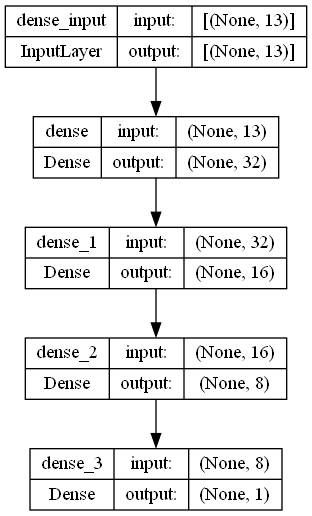

In [43]:
keras.utils.plot_model(model_boston, show_shapes = True)

#### 학습(Train)

In [44]:
hist = model_boston.fit(train_dataset, 
                        epochs = N_EPOCH,
                        validation_data = test_dataset)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 592.7670 - val_loss: 610.8075
Epoch 2/200
1/1 [==============================] - 0s 79ms/step - loss: 582.2697 - val_loss: 603.5632
Epoch 3/200
1/1 [==============================] - 0s 48ms/step - loss: 577.4246 - val_loss: 595.2667
Epoch 4/200
1/1 [==============================] - 0s 59ms/step - loss: 567.7039 - val_loss: 585.6584
Epoch 5/200
1/1 [==============================] - 0s 42ms/step - loss: 556.3108 - val_loss: 574.2402
Epoch 6/200
1/1 [==============================] - 0s 39ms/step - loss: 545.1740 - val_loss: 560.7397
Epoch 7/200
1/1 [==============================] - 0s 38ms/step - loss: 533.4029 - val_loss: 544.5043
Epoch 8/200
1/1 [==============================] - 0s 41ms/step - loss: 517.2045 - val_loss: 525.4392
Epoch 9/200
1/1 [==============================] - 0s 49ms/step - loss: 499.3381 - val_loss: 502.7787
Epoch 10/200
1/1 [==============================] - 0s 38ms/step - loss: 470.5678 - 

#### 결과 시각화
- 학습 시 epoch별 검증 결과를 시각화

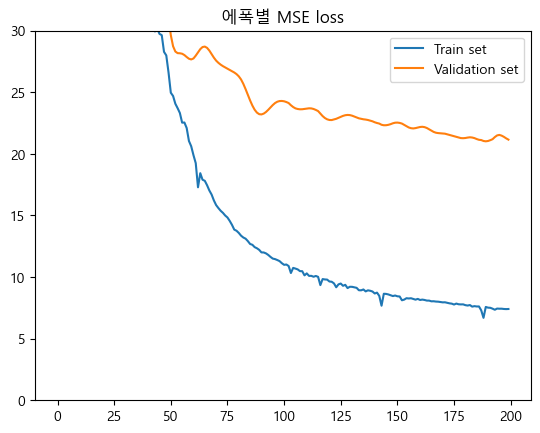

In [45]:
plt.plot(hist.epoch, hist.history['loss'], label='Train set')
plt.plot(hist.epoch, hist.history['val_loss'], label='Validation set')

plt.title('에폭별 MSE loss')
plt.ylim(0, 30)
plt.legend()
plt.show()

#### 최종 테스트

In [46]:
loss = model_boston.evaluate(test_dataset)

3/3 [==============================] - 0s 5ms/step - loss: 21.1566


#### 모델 네트워크 저장

In [47]:
import os
path = 'saved_model'
os.makedirs(path, exist_ok = True)

In [48]:
saved_dir = os.path.join(path, 'boston_model')
print(saved_dir)
model_boston.save(saved_dir)

saved_model\boston_model


INFO:tensorflow:Assets written to: saved_model\boston_model\assets


INFO:tensorflow:Assets written to: saved_model\boston_model\assets


#### 새로운 데이터 추론

In [49]:
# 저장된 모델 불러와 추론
saved_model = keras.models.load_model(saved_dir)
saved_model.evaluate(test_dataset)

3/3 [==============================] - 1s 8ms/step - loss: 21.1566


21.1566219329834

In [50]:
X_new = X_test[:5]
pred = saved_model.predict(X_new)
print(pred)

1/1 [==============================] - 0s 264ms/step
[[ 8.155615]
 [19.217352]
 [21.872103]
 [35.54864 ]
 [25.270071]]


In [51]:
y_test[:5]

array([ 7.2, 18.8, 19. , 27. , 22.2])